In [28]:
import tarfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext tensorboard
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
tf.version.VERSION

'2.0.0'

In [6]:
%run ../Scripts/download_script.py -i '1TqiNZdb72OYmvc-qOUCgtkYgPIHlY32s' -d 'Satellite_Image_Data.tar.gz'

In [7]:
with tarfile.open("Satellite_Image_Data.tar.gz") as tarf:
    tarf.extractall()

# Input Data

Setting up paths and constants for input.

In [8]:
input_images_dir = 'Satellite_Image_Data/Images/'
input_masks_dir = 'Satellite_Image_Data/Masks/'

In [9]:
TARGET_WIDTH = 256
TARGET_HEIGHT = 256

## Image Data Generation

In [10]:
data_gen_args = dict(shear_range=0,
                     zoom_range=0,
                     rotation_range=90,
                     rescale=1./255,
                     horizontal_flip=True)

train_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [11]:
img_generator = train_datagen.flow_from_directory(input_images_dir,
                                                  target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                  batch_size=32,
                                                  class_mode=None, 
                                                  seed=111, 
                                                  shuffle=False)

mask_generator = mask_datagen.flow_from_directory(input_masks_dir,
                                                  target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                  color_mode = 'grayscale',
                                                  batch_size=32,
                                                  class_mode=None, 
                                                  seed=111, 
                                                  shuffle=False)

Found 692 images belonging to 1 classes.
Found 692 images belonging to 1 classes.


In [12]:
train_generator = (pair for pair in zip(img_generator, mask_generator))

In [13]:
x, y = next(train_generator)

In [16]:
def pair_image_with_mask(img, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,)*3, axis=-1)

    return np.concatenate([img, mask], axis = 1)

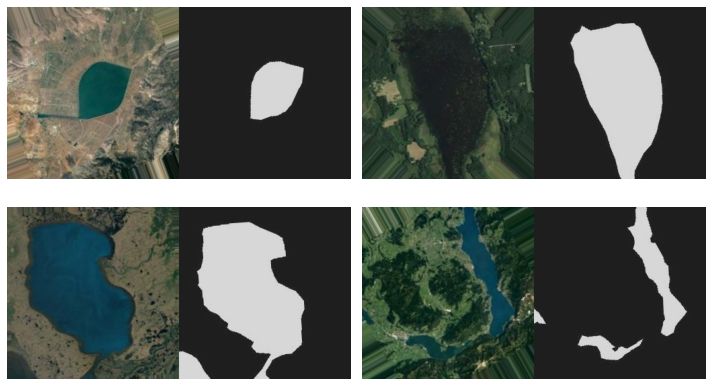

In [17]:
_, axs = plt.subplots(2, 2, figsize = (10, 6))
axs = axs.flatten()

for i in range (0, 4):
    combined = pair_image_with_mask(x[i], y[i])
    axs[i].axis('off')
    axs[i].imshow(combined)

plt.tight_layout()

In [18]:
validation_x = x
validation_y = y

In [19]:
from tensorflow.keras.layers import Concatenate, Conv2DTranspose

In [56]:
class unet():
    def __init__(self):

        self.lookback = []
        inputs = Input((TARGET_HEIGHT, TARGET_HEIGHT, 3))
        _tensor = inputs

        f = 8
        layers = []
        
        self.lookback.append('Downsampling')
        self.lookback.append(('Tensor size', _tensor.shape))
        for i in range(0, 6):
            self.lookback.append(('Convolution', i))
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            self.lookback.append(('Tensor size', _tensor.shape))
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            self.lookback.append(('Tensor size', _tensor.shape))
            self.lookback.append('Maxpool')
            layers.append(_tensor)
            _tensor = MaxPooling2D()(_tensor)
            f = f*2
            self.lookback.append(('Tensor size', _tensor.shape))

        self.lookback.append('Bottleneck')
        ff2 = 64
        j = len(layers) -1
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        _tensor = Conv2DTranspose(ff2, 2, strides = (2, 2), padding = 'same')(_tensor)
        
        self.lookback.append(('Tensor size', _tensor.shape))
        self.lookback.append('Concatenate')
        _tensor = Concatenate(axis = 3)([_tensor, layers[j]])
        self.lookback.append(('Tensor size', _tensor.shape))

        j = j-1
        self.lookback.append('Upsample')
        for i in range(0, 5):
            ff2 = ff2//2
            f = f//2
            self.lookback.append(('f',f, 'ff2', ff2))
            self.lookback.append(('Convolution', i))
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            self.lookback.append(('Tensor size', _tensor.shape))
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            self.lookback.append(('Tensor size', _tensor.shape))
            self.lookback.append('Conv2DTranspose')
            _tensor = Conv2DTranspose(ff2, 2, strides = (2, 2), padding = 'same')(_tensor)
            self.lookback.append(('Tensor size', _tensor.shape))
            self.lookback.append('Concatenate')
            _tensor = Concatenate(axis = 3)([_tensor, layers[j]])     
            self.lookback.append(('Tensor size', _tensor.shape))
            
            j = j - 1

        self.lookback.append('Last 2 convolution')
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        self.lookback.append(('Tensor size', _tensor.shape))
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        self.lookback.append(('Tensor size', _tensor.shape))

        self.lookback.append('Classification layer')
        outputs = Conv2D(1, 1, activation = 'sigmoid')(_tensor)
        self.lookback.append(('output size', outputs.shape))

        self._model = Model(inputs, outputs)
        self._model.compile(optimizer='rmsprop', loss='binary_crossentropy')

    def train(self, X, y, batch_size, num_epochs, callback):
        self._model.fit(X, y,
                        verbose = 1,
                        epochs = num_epochs,
                        batch_size = batch_size,
                        callbacks = [callback]
                       )

In [54]:
X_train, y_train = next(train_generator)

In [61]:
!rm -rf ./logs/ 

In [57]:
dae = unet()
callback = TensorBoard(log_dir = 'logs/fit/', histogram_freq = 1)
for X_train, y_train in train_generator:
    dae.train(X_train, y_train, 8, 20, callback)

Train on 32 samples
Epoch 1/20
32/32 [==============================] - 4s 125ms/sample - loss: 0.6636
Epoch 2/20
32/32 [==============================] - 1s 27ms/sample - loss: 0.6307
Epoch 3/20
32/32 [==============================] - 1s 28ms/sample - loss: 0.5525
Epoch 4/20
32/32 [==============================] - 1s 27ms/sample - loss: 0.5389
Epoch 5/20
32/32 [==============================] - 1s 28ms/sample - loss: 0.5308
Epoch 6/20
32/32 [==============================] - 1s 27ms/sample - loss: 0.5238
Epoch 7/20
32/32 [==============================] - 1s 28ms/sample - loss: 0.5125
Epoch 8/20
32/32 [==============================] - 1s 27ms/sample - loss: 0.5175
Epoch 9/20
32/32 [==============================] - 1s 27ms/sample - loss: 0.5027
Epoch 10/20
32/32 [==============================] - 1s 27ms/sample - loss: 0.4952
Epoch 11/20
32/32 [==============================] - 1s 27ms/sample - loss: 0.5034
Epoch 12/20
32/32 [==============================] - 1s 29ms/sample - loss:

In [60]:
display(len(dae.lookback))

82

In [44]:
%tensorboard --logdir logs/fit

In [59]:
dae._model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_243 (Conv2D)             (None, 256, 256, 8)  224         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_244 (Conv2D)             (None, 256, 256, 8)  584         conv2d_243[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_54 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_244[0][0]                 
____________________________________________________________________________________________

In [247]:
p = dae._model.predict(validation_x)

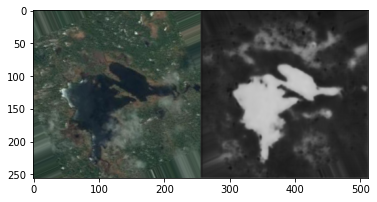

In [266]:
n = 31
m = np.squeeze(p[n])
m = np.stack((m,)*3, axis=-1)
m.shape
plt.imshow(np.concatenate([validation_x[n], m], axis = 1))

In [269]:
m = np.squeeze(p[n])
display(m[:5, :5])

array([[0.2732286 , 0.20928767, 0.20147294, 0.20876643, 0.21061316],
       [0.19659102, 0.12052998, 0.10953969, 0.11722699, 0.12165689],
       [0.19416413, 0.11169985, 0.10327619, 0.10916886, 0.1193966 ],
       [0.1908938 , 0.11581725, 0.1073716 , 0.11893144, 0.12788418],
       [0.19739208, 0.11910877, 0.11420977, 0.12093097, 0.13087907]],
      dtype=float32)

In [275]:
a = np.stack((m, )*2)

In [276]:
np.shape(a)

(2, 256, 256)

In [279]:
a[:, :5, :5]

array([[[0.2732286 , 0.20928767, 0.20147294, 0.20876643, 0.21061316],
        [0.19659102, 0.12052998, 0.10953969, 0.11722699, 0.12165689],
        [0.19416413, 0.11169985, 0.10327619, 0.10916886, 0.1193966 ],
        [0.1908938 , 0.11581725, 0.1073716 , 0.11893144, 0.12788418],
        [0.19739208, 0.11910877, 0.11420977, 0.12093097, 0.13087907]],

       [[0.2732286 , 0.20928767, 0.20147294, 0.20876643, 0.21061316],
        [0.19659102, 0.12052998, 0.10953969, 0.11722699, 0.12165689],
        [0.19416413, 0.11169985, 0.10327619, 0.10916886, 0.1193966 ],
        [0.1908938 , 0.11581725, 0.1073716 , 0.11893144, 0.12788418],
        [0.19739208, 0.11910877, 0.11420977, 0.12093097, 0.13087907]]],
      dtype=float32)

In [282]:
b = np.stack((m, )*3, axis = -1)

In [283]:
np.shape(b)

(256, 256, 3)

In [284]:
b[:5, :5, :]

array([[[0.2732286 , 0.2732286 , 0.2732286 ],
        [0.20928767, 0.20928767, 0.20928767],
        [0.20147294, 0.20147294, 0.20147294],
        [0.20876643, 0.20876643, 0.20876643],
        [0.21061316, 0.21061316, 0.21061316]],

       [[0.19659102, 0.19659102, 0.19659102],
        [0.12052998, 0.12052998, 0.12052998],
        [0.10953969, 0.10953969, 0.10953969],
        [0.11722699, 0.11722699, 0.11722699],
        [0.12165689, 0.12165689, 0.12165689]],

       [[0.19416413, 0.19416413, 0.19416413],
        [0.11169985, 0.11169985, 0.11169985],
        [0.10327619, 0.10327619, 0.10327619],
        [0.10916886, 0.10916886, 0.10916886],
        [0.1193966 , 0.1193966 , 0.1193966 ]],

       [[0.1908938 , 0.1908938 , 0.1908938 ],
        [0.11581725, 0.11581725, 0.11581725],
        [0.1073716 , 0.1073716 , 0.1073716 ],
        [0.11893144, 0.11893144, 0.11893144],
        [0.12788418, 0.12788418, 0.12788418]],

       [[0.19739208, 0.19739208, 0.19739208],
        [0.11910877, 0.119